# YOHO training

In [1]:
import os 
os.chdir('/Users/davidecapone/Documents/YOHO24/')

In [2]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [3]:
# Import used libraries

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")


from yoho24.utils import AudioClip, AudioFile, TUTDataset, YOHODataGenerator

pandas version: 1.5.3
matplotlib version: 3.6.3
librosa version: 0.10.2.post1
torch version: 2.3.1


In [4]:
def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 1.00,
    hop_len: float = 1.00,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        x_axis="frames",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## Data generator

In [5]:
N_MELS = 40
WIN_S = 0.04 # 40 ms
HOP_S = 0.01 # 10 ms

In [6]:
audios = [
    AudioFile(filepath=file.filepath, labels=eval(file.events))
    for _, file in pd.read_csv(
        "./data/processed/TUT/TUT-sound-events-2017-development.csv"
    ).iterrows()
]

audioclips = [
    audioclip
    for _, audio in enumerate(audios)
    for audioclip in audio.subdivide(win_len=2.56, hop_len=1.96)
    if _ < 1
]

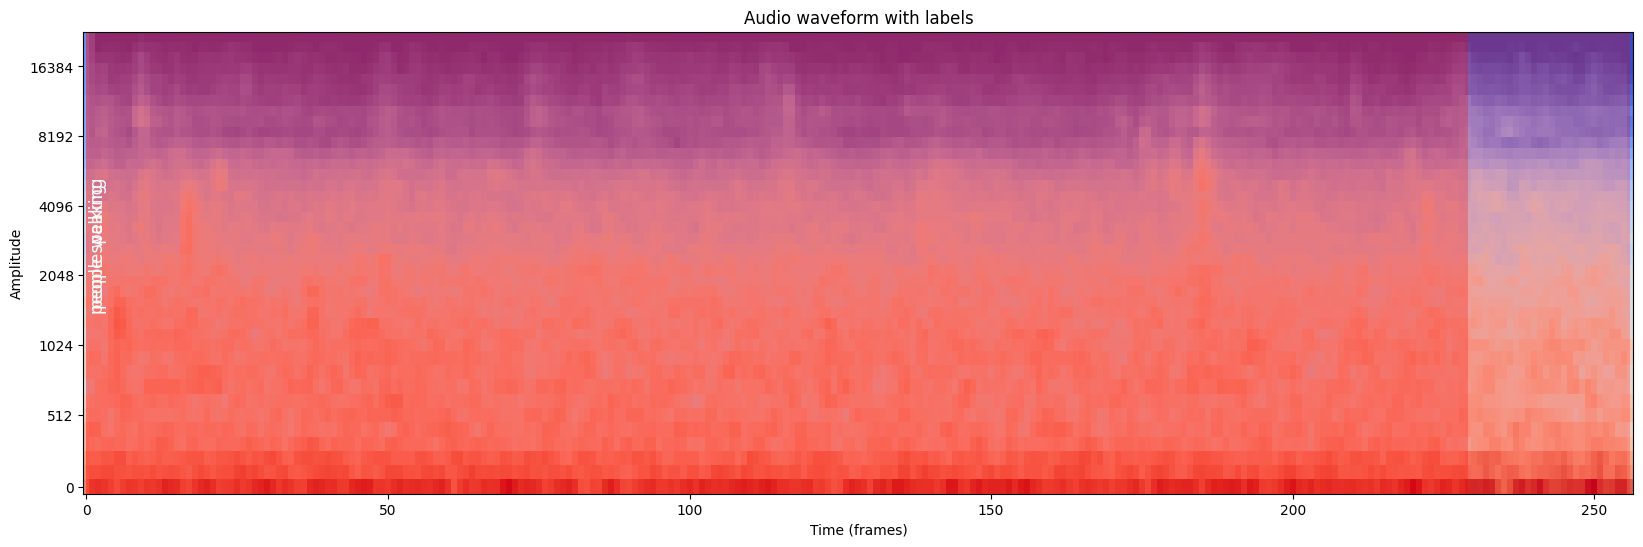

In [7]:
audioclips[25].plot_labels()

In [8]:
N_MELS = 40
HOP_MS = 10
WIN_MS = 40

tut_train = TUTDataset(
    audios=audioclips,
)

print(f"Number of audio files: {len(tut_train)}")
print(f"Duration: {tut_train.audios[0].duration} seconds")
print(f"Sampling rate: {tut_train.audios[0].sr} Hz")

Number of audio files: 153
Duration: 2.56 seconds
Sampling rate: 44100 Hz


In [51]:
train_dataloader = YOHODataGenerator(tut_train, batch_size=4, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train features shape: torch.Size([4, 1, 40, 257])
Train labels shape: torch.Size([4, 9, 18])


In [52]:
from yoho24.yoho import YOHO

model = YOHO(input_shape=train_features.shape, output_shape=train_labels.shape)
prediction = model(train_features)
prediction.shape

torch.Size([4, 4, 494])

In [53]:
from torchsummary import summary

summary(
    YOHO(input_shape=(4, 1, 64, 801), output_shape=(4, 1, 6, 26)), input_size=(1, 64, 801), batch_size=4
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 32, 32, 401]             288
       BatchNorm2d-2           [4, 32, 32, 401]              64
              ReLU-3           [4, 32, 32, 401]               0
            Conv2d-4           [4, 32, 32, 401]             288
       BatchNorm2d-5           [4, 32, 32, 401]              64
              ReLU-6           [4, 32, 32, 401]               0
            Conv2d-7           [4, 64, 34, 403]           2,048
       BatchNorm2d-8           [4, 64, 34, 403]             128
              ReLU-9           [4, 64, 34, 403]               0
          Dropout-10           [4, 64, 34, 403]               0
DepthwiseSeparableConv-11           [4, 64, 34, 403]               0
           Conv2d-12           [4, 64, 17, 202]             576
      BatchNorm2d-13           [4, 64, 17, 202]             128
             ReLU-14           [4,

In [32]:
import torch.nn as nn
from torchsummary import summary


input_shape = (4, 1, 64, 801)

# Define a model with a Conv2D layer
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=32, kernel_size=(3, 3), stride=2, padding=1
    ),
    nn.BatchNorm2d(32, eps=1e-4),
    nn.ReLU(),

    
    nn.Conv2d(
        in_channels=32,
        out_channels=32,
        kernel_size=(3, 3),
        padding=1,
        groups=32,
        bias=False,
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=32, out_channels=64, kernel_size=(1, 1)
    ),
    nn.ReLU(),
)

# Print the model summary
summary(model, input_shape)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 4, 1, 64, 801]